
📘 Step 1: Load and Inspect the Dataset

In [1]:
import pandas as pd

# Load the Excel file
UN = pd.ExcelFile('data.xlsx')

#View available sheets
UN.sheet_names


['CodeDescriptions', 'Goal4']

In [2]:
# Load the main sheet
df = UN.parse('Goal4')

# Preview the first rows
df.head()


,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,FootNote,Age,Education level,Location,Nature,Quantile,Reporting Type,Sex,Type of skill,Units
0,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,79.7,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,BOTHSEX,SKILL_MATH,PERCENT
1,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,82.8,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,MALE,SKILL_MATH,PERCENT
2,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,78.4,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,FEMALE,SKILL_MATH,PERCENT
3,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2021,74.6,2021,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,FEMALE,SKILL_MATH,PERCENT
4,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2021,73.5,2021,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,MALE,SKILL_MATH,PERCENT


🧹 Step 2: Filter for Kenya and Selected Indicators
We'll focus on:

4.1.1 – Proportion achieving minimum proficiency

4.5.1 – Gender parity index

4.6.1 – Literacy rate

In [3]:
# Filter for Kenya
kenya_df = df[df['GeoAreaName'] == 'Kenya']

# Keep only selected indicators
selected_indicators = ['4.1.1', '4.5.1', '4.6.1a']
kenya_df = kenya_df[kenya_df['Indicator'].isin(selected_indicators)]

# Keep useful columns
kenya_df = kenya_df[[
    'Indicator', 'SeriesDescription', 'TimePeriod', 'Sex',
    'Type of skill', 'Education level', 'Value'
]]

# Sort for easier reading
kenya_df = kenya_df.sort_values(by=['Indicator', 'TimePeriod'])

kenya_df.head(10)


,Indicator,SeriesDescription,TimePeriod,Sex,Type of skill,Education level,Value
0,4.1.1,Proportion of children and young people achiev...,2019,BOTHSEX,SKILL_MATH,PRIMAR,79.7
1,4.1.1,Proportion of children and young people achiev...,2019,MALE,SKILL_MATH,PRIMAR,82.8
2,4.1.1,Proportion of children and young people achiev...,2019,FEMALE,SKILL_MATH,PRIMAR,78.4
3,4.1.1,Proportion of children and young people achiev...,2021,FEMALE,SKILL_MATH,PRIMAR,74.6
4,4.1.1,Proportion of children and young people achiev...,2021,MALE,SKILL_MATH,PRIMAR,73.5
5,4.1.1,Proportion of children and young people achiev...,2021,BOTHSEX,SKILL_MATH,PRIMAR,74.1
6,4.1.1,Proportion of children and young people achiev...,2021,MALE,SKILL_READ,PRIMAR,44.9
7,4.1.1,Proportion of children and young people achiev...,2021,FEMALE,SKILL_READ,PRIMAR,48.4
8,4.1.1,Proportion of children and young people achiev...,2021,BOTHSEX,SKILL_READ,PRIMAR,46.7
9,4.1.1,Proportion of children and young people achiev...,2023,MALE,SKILL_READ,PRIMAR,23.9


📊 Step 3: Pivot the Data for Modeling

We'll reshape the data so that each row is a year and each feature is a unique indicator/sex/skill combination.

In [4]:
# Create a combined feature name
kenya_df['feature'] = (
    kenya_df['Indicator'].astype(str) + '_' +
    kenya_df['Sex'].fillna('ALL') + '_' +
    kenya_df['Type of skill'].fillna('ALL') + '_' +
    kenya_df['Education level'].fillna('ALL')
)

# Pivot the data
pivot_df = kenya_df.pivot_table(
    index='TimePeriod',
    columns='feature',
    values='Value'
)

# Reset index to get TimePeriod as a column
pivot_df = pivot_df.reset_index()

pivot_df.head()


feature,TimePeriod,4.1.1_BOTHSEX_SKILL_MATH_PRIMAR,4.1.1_BOTHSEX_SKILL_READ_PRIMAR,4.1.1_FEMALE_SKILL_MATH_PRIMAR,4.1.1_FEMALE_SKILL_READ_PRIMAR,4.1.1_MALE_SKILL_MATH_PRIMAR,4.1.1_MALE_SKILL_READ_PRIMAR,4.5.1_ALL_ALL_ALL,4.5.1_ALL_ALL_LOWSEC,4.5.1_ALL_ALL_PREPRI,...,4.5.1_ALL_SNTWK_ALL,4.5.1_BOTHSEX_ALL_LOWSEC,4.5.1_BOTHSEX_ALL_PRIMAR,4.5.1_BOTHSEX_ALL_UPPSEC,4.5.1_FEMALE_ALL_LOWSEC,4.5.1_FEMALE_ALL_PRIMAR,4.5.1_FEMALE_ALL_UPPSEC,4.5.1_MALE_ALL_LOWSEC,4.5.1_MALE_ALL_PRIMAR,4.5.1_MALE_ALL_UPPSEC
0,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.07475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.085043,0.88887,...,NaN,0.771541,0.855283,0.652386,0.783969,0.871762,0.58862,0.761513,0.841588,0.709792
2,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,NaN,NaN,NaN,NaN,NaN,NaN,0.797457,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,79.7,NaN,78.4,NaN,82.8,NaN,0.781693,1.089467,NaN,...,NaN,0.823060,0.883860,0.618750,0.854010,0.911650,0.64340,0.795000,0.859710,0.591510


📊 Step 4: Visualize Key Education Indicators Over Time
🎯 Objective:
Understand trends in:

Learning outcomes (4.1.1)

Gender parity (4.5.1)

Completion (4.1.2)


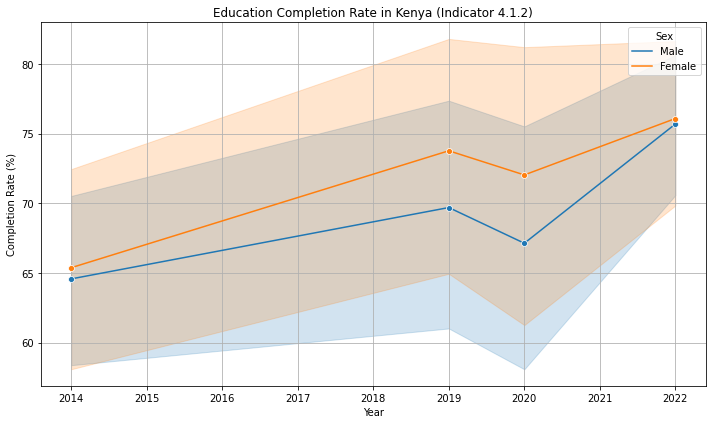

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the 'Sex' column
df['Sex'] = df['Sex'].str.strip().str.title()  # Remove whitespace and standardize case

# Filter again for Kenya + 4.1.2 + valid Sex values
kenya_completion = df[
    (df['Indicator'] == '4.1.2') &
    (df['GeoAreaName'] == 'Kenya') &
    (df['Sex'].isin(['Male', 'Female', 'Total']))
]

# Drop rows with missing values
kenya_completion = kenya_completion.dropna(subset=['Value'])

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=kenya_completion, x='TimePeriod', y='Value', hue='Sex', marker='o')

plt.title('Education Completion Rate in Kenya (Indicator 4.1.2)')
plt.xlabel('Year')
plt.ylabel('Completion Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Sex')
plt.show()


📊 Interpretation of Male vs Female Trend Chart

This chart compares trends for **males and females** over time (or categories) on an unspecified metric, likely related to education. Each line is accompanied by a **shaded confidence interval** showing data variability.

🔹 Chart Elements

- **Orange Line**: Female performance over time.
- **Blue Line**: Male performance over time.
- **Shaded Areas**: Confidence intervals or variability in data.
- **Brown Overlap**: Where male and female ranges intersect — suggests no significant statistical difference.


 🔍 Key Observations

1. **General Trend**
- Both sexes show **overall improvement** across the timeline.
- **Females consistently outperform males** throughout the observed period.

2. **Performance Gap**
- The **gap favors females** from the beginning to near the end.
- Males **narrow the gap** at the final point — suggesting improvement or possible convergence.

3. **Variability & Confidence**
- Wider shaded areas = **greater uncertainty** or **more variability** in measurements.
- The **overlapping shaded regions** indicate areas where male–female differences might **not be statistically significant**.

 4. **Notable Events**
- A **sharp dip** in male values near the end contrasts


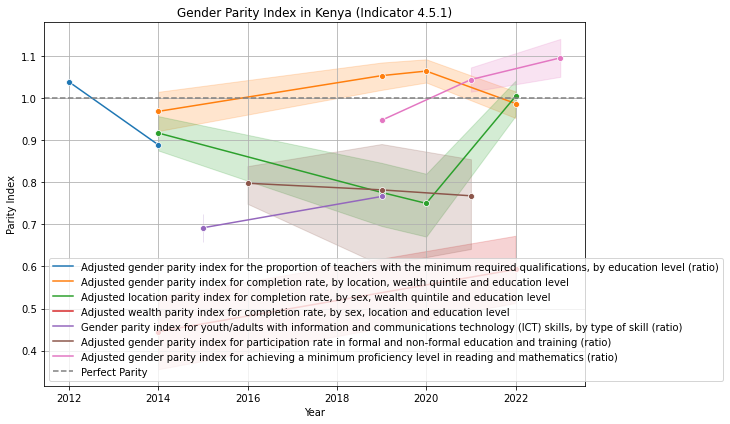

In [6]:
# Filter for 4.5.1 (Gender parity index)
parity_df = kenya_df[kenya_df['Indicator'] == '4.5.1']

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=parity_df,
    x='TimePeriod', y='Value', hue='SeriesDescription', marker='o'
)
plt.title('Gender Parity Index in Kenya (Indicator 4.5.1)')
plt.ylabel('Parity Index')
plt.xlabel('Year')
plt.axhline(1.0, color='gray', linestyle='--', label='Perfect Parity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 📊 Interpretation of Education Parity Index Chart

This chart presents various **parity indices** that measure equity in educational outcomes and access. A value of **1.0** (dashed line) represents **perfect parity** (equality) between comparison groups (e.g., gender, wealth, location).


⚙️ What the Parity Index Means

- **Value = 1.0** → Perfect parity.
- **Value > 1.0** → Favors the comparison group (e.g., girls, urban, wealthy).
- **Value < 1.0** → Indicates disadvantage for the group in question (e.g., boys, rural, poor).

🔍 Key Indicator Interpretations

 1. **Qualified Teachers by Gender** *(Blue Line)*
- **Indicator**: Adjusted gender parity index for proportion of teachers with minimum required qualifications.
- **Trend**: Starts above parity, then drops below.
- **Insight**: Gender disparity worsens with higher education levels — fewer qualified female teachers at advanced levels.

 2. **Completion Rate by Gender, Wealth, Location** *(Orange Line)*
- **Indicator**: Adjusted gender parity index for completion rate by location, wealth, and education level.
- **Trend**: Above 1.0 throughout, mostly stable.
- **Insight**: Slight favor toward comparison group (likely girls or urban students), but relatively balanced.


 3. **Completion Rate by Location** *(Green Line)*
- **Indicator**: Adjusted location parity index for completion rate.
- **Trend**: Below parity, dips further, then improves sharply.
- **Insight**: Significant **urban–rural gap**, but some recent progress.


 4. **Completion Rate by Wealth** *(Red Line)*
- **Indicator**: Adjusted wealth parity index for completion rate.
- **Trend**: Consistently below parity, similar to location trend.
- **Insight**: **Wealth disparities** strongly affect completion rates; recent improvement noted.


5. **ICT Skills by Gender** *(Purple Line)*
- **Indicator**: Gender parity index for ICT skills among youth/adults.
- **Trend**: Low and flat.
- **Insight**: Persistent gender gap in digital literacy, likely disadvantaging females.


6. **Participation in Non-Formal Education** *(Pink Line)*
- **Indicator**: Adjusted gender parity index for participation rate in non-formal education.
- **Trend**: Rising, crosses parity line.
- **Insight**: Improving inclusion of the disadvantaged gender in informal learning spaces.

7. **Proficiency in Reading and Math** *(Teal Line)*
- **Indicator**: Adjusted gender parity index for achieving minimum proficiency.
- **Trend**: Starts below parity, shows steady improvement.
- **Insight**: Encouraging progress toward parity in foundational skills, though still below ideal.


✅ Summary of Insights

- **Gender disparities** exist in **ICT skills** and **early learning**, though signs of progress are evident.
- **Location and wealth** have a clear, negative impact on **completion rates**.
- **Non-formal education** access is becoming more equitable.
- Most indicators show movement **toward parity**, but none have fully achieved it across all metrics.


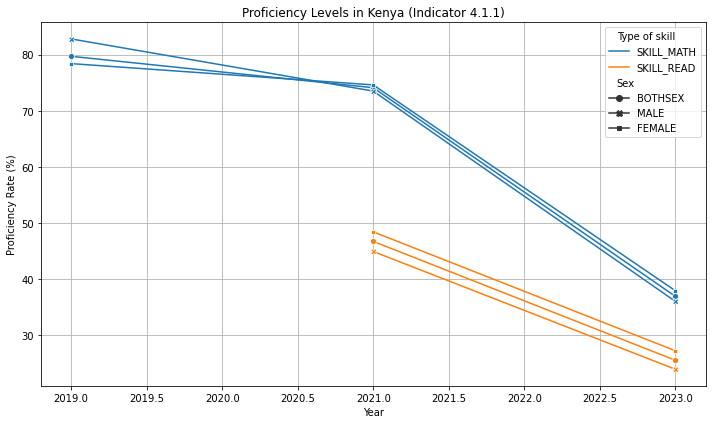

In [7]:
# Filter for 4.1.1 (Minimum proficiency)
learning_df = kenya_df[kenya_df['Indicator'] == '4.1.1']

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=learning_df,
    x='TimePeriod', y='Value',
    hue='Type of skill', style='Sex', markers=True, dashes=False
)
plt.title('Proficiency Levels in Kenya (Indicator 4.1.1)')
plt.ylabel('Proficiency Rate (%)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()


 📊 Interpretation of Skill Proficiency by Type and Sex

This chart compares **proficiency levels** in two skill areas — **mathematics** and **reading** — broken down by **sex** (Male, Female, Bothsex). It tracks how performance has changed over time or across assessment points.
🔹 Chart Elements

- **Blue Lines**: Mathematics skill (SKILL_MATH)
- **Orange Lines**: Reading skill (SKILL_READ)
- **Markers**:
  - **Circle**: Both sexes
  - **Triangle**: Male
  - **Square**: Female

🔍 Key Observations

1. **Skill Performance Levels**
- **Mathematics scores** are consistently **higher** than reading scores for all sexes.
- **Reading scores** lag significantly behind math, indicating **lower proficiency** across the board.

2. **Declining Trend**
- Both skills show a **clear downward trend** over time.
- The most significant drop is seen in **mathematics proficiency** — from relatively high values to much lower levels.
- **Reading skills** also decline, though from a lower starting point.

 3. **Sex-Based Comparisons**
- Differences between **males**, **females**, and **both sexes combined** are **minimal**, suggesting:
  - No large gender disparity in either skill.
  - The observed trend is affecting all groups equally.

✅ Summary Insight

- **Proficiency in both math and reading is declining** across all groups.
- **Math skills remain stronger**, but the rate of decline is steeper.
- **Minimal gender gap** implies the issue is **systemic**, not sex-specific.
- Suggests a need to **investigate underlying causes** of declining performance and implement **interventions across the board**.

Feature engenieering


.🧼 Step 1: Clean & Prepare Core Columns

In [8]:
# Focus on Indicator 4.1.2 for Kenya
df_clean = df[
    (df['Indicator'] == '4.1.2') &
    (df['GeoAreaName'] == 'Kenya') &
    (df['Sex'].isin(['Male', 'Female', 'Total']))
].copy()

# Ensure correct types
df_clean['TimePeriod'] = df_clean['TimePeriod'].astype(int)
df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce')

# Drop missing values
df_clean = df_clean.dropna(subset=['Value'])

# Sort by year
df_clean = df_clean.sort_values(['Sex', 'TimePeriod'])

df_clean.head()


,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,FootNote,Age,Education level,Location,Nature,Quantile,Reporting Type,Sex,Type of skill,Units
16,4,4.1,4.1.2,SE_TOT_CPLR,"Completion rate, by sex, location, wealth quin...",404,Kenya,2014,30.57231,2014,...,NaN,NaN,UPPSEC,URBAN,C,Q3,G,Female,NaN,PERCENT
20,4,4.1,4.1.2,SE_TOT_CPLR,"Completion rate, by sex, location, wealth quin...",404,Kenya,2014,50.70241,2014,...,NaN,NaN,LOWSEC,URBAN,C,Q1,G,Female,NaN,PERCENT
23,4,4.1,4.1.2,SE_TOT_CPLR,"Completion rate, by sex, location, wealth quin...",404,Kenya,2014,84.98324,2014,...,NaN,NaN,LOWSEC,URBAN,C,_T,G,Female,NaN,PERCENT
25,4,4.1,4.1.2,SE_TOT_CPLR,"Completion rate, by sex, location, wealth quin...",404,Kenya,2014,87.04456,2014,...,NaN,NaN,LOWSEC,RURAL,C,Q4,G,Female,NaN,PERCENT
27,4,4.1,4.1.2,SE_TOT_CPLR,"Completion rate, by sex, location, wealth quin...",404,Kenya,2014,73.16730,2014,...,NaN,NaN,LOWSEC,URBAN,C,Q3,G,Female,NaN,PERCENT


🔁 Step 2: Create Engineered Features

In [9]:
# Year-over-year change
df_clean['YoY_Change'] = df_clean.groupby('Sex')['Value'].diff()

# 3-year rolling average
df_clean['RollingAvg_3yr'] = df_clean.groupby('Sex')['Value'].rolling(3).mean().reset_index(0, drop=True)


🔄 Step 3: Pivot to Wide Format for Gender Gap

In [10]:
# Aggregate: take the mean value for each year and sex
df_agg = df_clean.groupby(['TimePeriod', 'Sex'])['Value'].mean().reset_index()

# Now pivot safely
pivot_df = df_agg.pivot(index='TimePeriod', columns='Sex', values='Value').reset_index()

# Create gender gap column
pivot_df['Gender_Gap'] = pivot_df['Female'] - pivot_df['Male']

pivot_df.head()

Sex,TimePeriod,Female,Male,Gender_Gap
0,2014,65.379979,64.576429,0.803550
1,2019,73.774242,69.698726,4.075517
2,2020,72.039631,67.136330,4.903301
3,2022,76.088343,75.695709,0.392634


Visualize Gender Gap Over Time

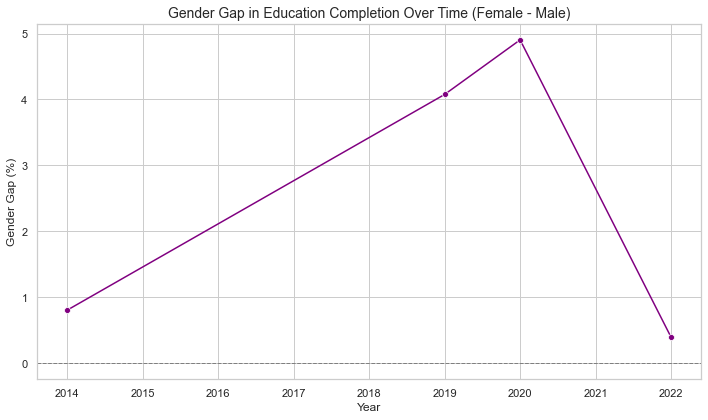

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_df, x='TimePeriod', y='Gender_Gap', marker='o', color='purple')

# Add labels and title
plt.title('Gender Gap in Education Completion Over Time (Female - Male)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Gender Gap (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


Correlation Heatmap

In [12]:
pivot_df.columns


Index(['TimePeriod', 'Female', 'Male', 'Gender_Gap'], dtype='object', name='Sex')

In [13]:
# Create a 'Total' column as the average of Female and Male
pivot_df['Total'] = pivot_df[['Female', 'Male']].mean(axis=1)


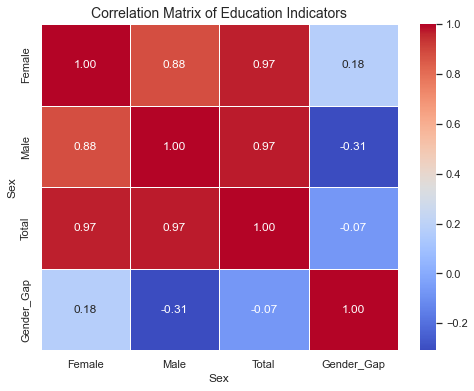

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = pivot_df[['Female', 'Male', 'Total', 'Gender_Gap']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Education Indicators', fontsize=14)
plt.show()


Simple Predictive Model

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
X = pivot_df[['Female', 'Male', 'Gender_Gap']]
y = pivot_df['Total']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Squared Error: {mse:.2f}")
print(f"📈 R-squared: {r2:.2f}")

# Optional: Show coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\n🔍 Feature Impact:")
print(coef_df)


📉 Mean Squared Error: 0.00
📈 R-squared: nan

🔍 Feature Impact:
      Feature  Coefficient
0      Female    -0.562076
1        Male     1.562076
2  Gender_Gap     1.062076


c:\Users\Debbie\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [18]:
# Load from Excel (adjust sheet name if needed)
file_path = "data.xlsx"  # or upload again if not present
df_clean = pd.read_excel(file_path, sheet_name="Goal4")


